### 5.1.1 A Simple example

앞장에서 소개한 기본 입자 필터에 대한 사용법을 소개하고 그 정확성을 평가하기 위해 매우 단순한 예제를 소개하겠습니다. 이 예제에서는 이미 알고 있는 DLM에서 시뮬레이션 한 100개의 관측치를 고려해 보겠습니다. 이 관측치 데이터는 초기 상태 분포가 $N(10,9)$이고, 시스템 분산이 $W=1$, 관측 분산이 $V=2$인 local level 모델(=1차 가우시안 동적 선형 모델)로 생산하였습니다. 관측 데이터는 변수 $y$에 저장하였습니다. **dlmForecast** 함수를 사용하면 주어진 모델에 대한 시뮬레이션을 수행할 수 있습니다.

**참고**

dlmModPoly(1,dV=2,dW=2,m0=10,C0=9) : 1차, 관측분산 V=2, 시스템분산 W=2, 초기평균 m0=10, 초기분산 C0=9인 모델f을 생성함. 


dlmModPoly 함수는 m0, C0, FF, V, GG, W 등을 return 함.


dlm에서 사용하는 상태공간방정식은 아래의 형태임.


$$y_t=F_t\theta_t+v_t,\;\;\;\;v_t\sim N(0,V_t)$$


$$\theta_t=G_t\theta_{t-1}+w_t,\;\;\;\;w_t \sim N(0,W_t)$$


$$\theta_0\sim N(m0,C0)$$

In [1]:
require("dlm")

Loading required package: dlm
Warning message:
"package 'dlm' was built under R version 3.6.3"

In [2]:
### 모델 생성
mod <- dlmModPoly(1, dV=2, dW=1, m0=10, C0=9)
names(mod) # mod가 가지는 변수들 나열

[1] "m0"  "C0"  "FF"  "V"   "GG"  "W"   "JFF" "JV"  "JGG" "JW"

In [3]:
## 생성 데이터 수
n <- 100
## seed 고정
set.seed(23)
## 데이터 생성
# mod 모델을 사용하고, n번째 까지 생성, 샘플데이터(newObs, newStates) 생성(sampleNew=1)
simData <- dlmForecast(mod = mod, nAhead = n, sampleNew = 1)
names(simData) # simData가 가지는 변수들 나열
# a = 상태평균, R = 상태분산, f = 관측평균, Q=관측분산
# 상기 변수들로 샘플링한 상태 및 관측치 = newStates, newObs

[1] "a"         "R"         "f"         "Q"         "newStates" "newObs"

In [4]:
## 관측 데이터만 y에 저장
y <- simData$newObs[[1]]

입자의 수를 1000으로 설정하고 입자필터를 수행하였습니다. 그리고 최적 중요도 커널을 중요도 전이 밀도로 사용하였습니다. 앞장에서 논의했듯이 DLM의 경우 이 밀도는 이 밀도로 부터 샘플링을 하고 입자 가중치를 업데이트하는데 사용하기 쉽습니다. 그리고 문제를 조금 단순하게 하기 위해 더 효율적인 잔차 리샘플링을 사용하지 않고 단순 다항 리샘플링을 사용했습니다. 그리고 리샘플링 단계를 위한 기준 값을 500으로 설정했습니다. 이는 유효 샘플 크기가 입자 수의 절반보다 적어지면 리샘플을 수행함을 의미합니다.

In [5]:
## 입자수
N <- 1000
## 리샘플 기준치
N_0 <- N / 2
## 입자필터 결과를 저장할 행렬
# 실수 type의 n+1(데이터수) x N(입자수) 행렬 정의
pfOut <- matrix(NA_real_, n+1, N)
## 가중치를 저장할 행렬
# 실수 type의 n+1(데이터수) x N(입자수) 행렬 정의
wt <- matrix(NA_real_, n+1, N)

**참고**

최적 중요도 커널 $g_{t|t-1}$의 중요도 전이 밀도는 다음의 평균 및 분산을 따르는 정규분포 임.

$$E(\theta_t|\theta_{t-1},y_t)=G_t\theta_{t-1}+W_tF_t'\Sigma_t^{-1}(y_t-F_tG_g\theta_{t-1})$$

$$Var(\theta_t|\theta_{t-1},y_t)=W_t-W_tF_t'\Sigma_t^{-1}F_tW_t$$

with

$$\Sigma_t=F_tW_tF_t'+V_t$$

In [6]:
## 중요도 전이 밀도의 표준편차
W <- mod$W
V <- mod$V
F <- mod$FF
G <- mod$GG
m0 <- mod$m0
C0 <- mod$C0
Sig = F*W*F+V
importnaceSd <- sqrt(W - W*F/Sig*F*W)
## 측정 전이 표준편차
predSd <- sqrt(Sig)

In [7]:
## 사전 분포를 사용해 초기 값 샘플링
pfOut[1,] <- rnorm(N, mean = m0, sd = sqrt(C0))

In [8]:
## 초기 가중치
wt[1,] <- rep(1/N,N)

In [9]:
options(warn=-1)  # warning 메세지 끄기
for (it in 2 : (n+1)){
    ## 입자 생성
    # 중요도 전이 밀도의 평균
    E <- G*pfOut[it-1,] + W*F/Sig*(y[it-1]-F*G*pfOut[it-1,])
    # 중요도 전이 밀도로 부터 샘플링
    pfOut[it,] <- rnorm(N, mean = E, sd = importnaceSd)
    ## 가중치 업데이트
    wt[it,] <- wt[it-1] * dnorm(y[it-1], mean = pfOut[it-1,], sd = sqrt(Sig))
    ## 가중치 정규화
    wt[it,] <- wt[it,] / sum(wt[it,])
    ## 필요 시 리샘플
    # 유효샘플크기 계산
    N.eff <- 1 / crossprod(wt[it,])
    if (N.eff < N_0)  # 리샘플 기준보다 작으면,
    {
        ## 다항 리샘플링
        index <- sample(N, N, replace = TRUE, prob = wt[it,])
        pfOut[it,] <- pfOut[it, index]
        # 가중치 초기화
        wt[it,] <- 1 / N
    }
}

완전히 정의된(알지 못하는 변수가 없는) DLM의 경우 칼만필터를 사용해 정확한 필터링 평균 및 분산을 구할 수 있습니다. 그림 5.1은 칼만필터로 구한 정확한 필터링 평균 및 분산과 입자 필터 알고리즘으로 구한 결과를 비교한 것입니다. 필터링 평균의 경우 입자 필터는 매우 높은 정확도를 보입니다. (두개의 선을 거의 구별할 수 없습니다.) 필터링 표준편차의 경우 덜 정확하지만 나름 실제 값에 근접한 결과를 보입니다. 입자의 수를 증가시키면 정확도를 높일 수 있습니다. 그림 5.1은 다음의 코드로 작성한 것입니다.

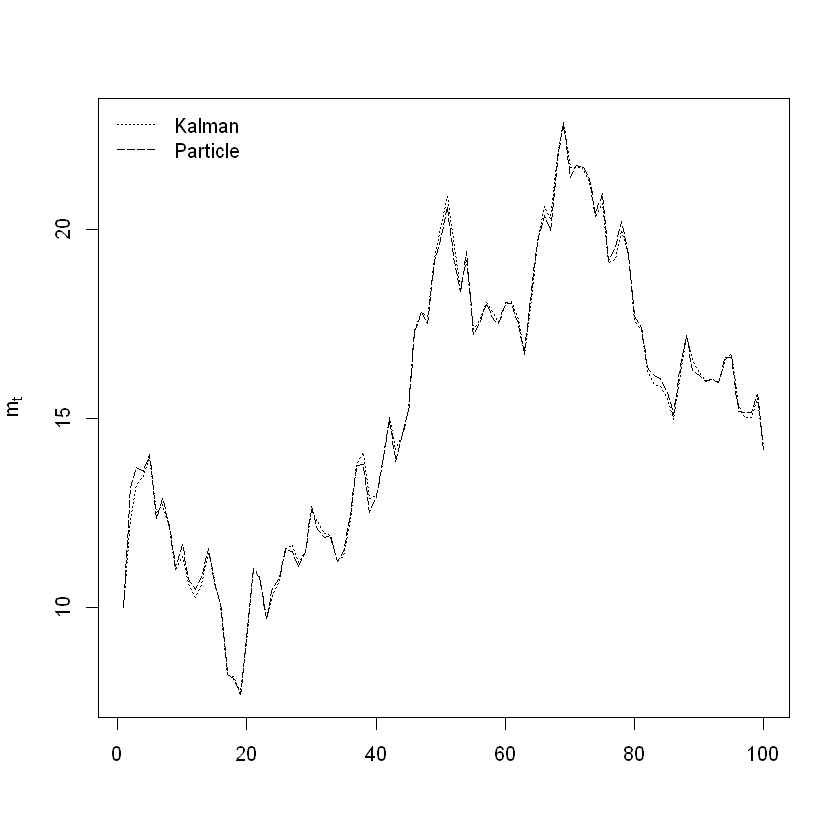

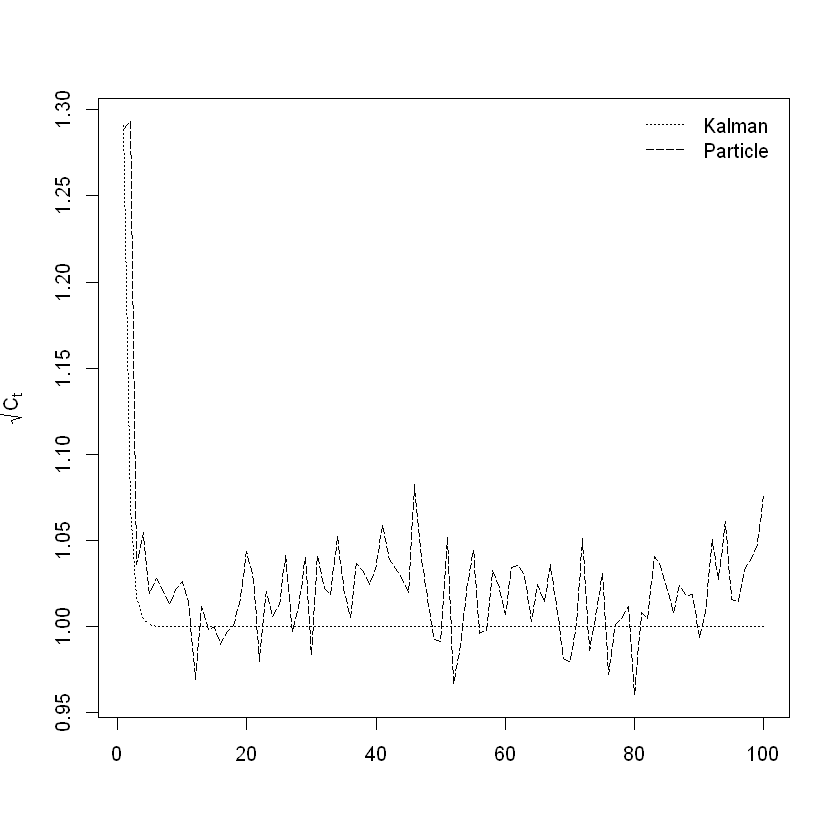

In [10]:
modFilt <- dlmFilter(y, mod)
thetaHatKF <- modFilt$m[-1]
sdKF <- with(modFilt, sqrt(unlist(dlmSvd2var(U.C, D.C))))[-1]
pfOut <- pfOut[-1,]
wt <- wt[-1,]
thetaHatPF <- sapply(1 : n, function(i)
                            weighted.mean(pfOut[i,],wt[i,]))
sdPF <- sapply(1:n, function(i)
                      sqrt(weighted.mean((pfOut[i,]-
                                    thetaHatPF[i])^2, wt[i,])))
plot.ts(cbind(thetaHatKF, thetaHatPF),
        plot.type = "s", lty = c("dotted", "longdash"),
        xlab = "", ylab = expression(m[t]))
legend("topleft", c("Kalman", "Particle"),
        lty = c("dotted", "longdash"), bty = "n")
plot.ts(cbind(sdKF, sdPF), plot.type="s",
        lty = c("dotted", "longdash"), xlab = "",
        ylab = expression(sqrt(C[t])))
legend("topright", c("Kalman", "Particle"),
        lty = c("dotted", "longdash"), bty = "n")